#### Author: Michał Hetmańczuk
# Recruitment Task
## Task 1: Phrase scoring


### Used libraries: 

In [1]:
import ast
import math
import pandas as pd

### Importing dataset:

In [2]:
scrapes_dataset = pd.read_csv('scrapes.csv')
scrapes_dataset.head()

,scrape_id,scrape_keyword,crawled_page_id,crawled_page_url,words,scores
0,244568,seo course 2020,3242198,https://www.quicksprout.com/best-seo-courses-a...,"[""our"", ""content"", ""is"", ""reader"", ""supported""...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,244568,seo course 2020,3242200,https://digitaldefynd.com/best-seo-courses-tra...,"[""skip"", ""to"", ""content"", ""trending"", ""10"", ""b...","[3, 3, 3, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,244568,seo course 2020,3242201,https://www.trumplearning.com/best-seo-course-...,"[""toggle"", ""navigation"", ""contact"", ""us"", ""hom...","[6, 6, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,244568,seo course 2020,3242199,https://ippei.com/best-seo-course/,"[""currently"", ""set"", ""to"", ""index"", ""currently...","[0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 7, 7, 7, ..."
4,244568,seo course 2020,3242195,https://www.searchenginejournal.com/best-free-...,"[""seo"", ""all"", ""seo"", ""ask"", ""an"", ""seo"", ""beg...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Removing erroneous entries from the data set:

In [3]:
# check if word is empty or contains blank chars (many words in one word)
def check_if_word_proper(word, word_index, logs_set, broken_indices_set):
    if ' ' in word:
        logs_set['complex_terms'] += 1
        broken_indices_set.add(word_index)
    if not word:
        logs_set['empty_words'] += 1
        broken_indices_set.add(word_index)

# filter word and score at given position
def filter_wrong_words(words_list, scores_list, broken_indices_set):
    for i, word in enumerate(words_list):
      words_list[i] = word.strip()
      check_if_word_proper(word, i, dataset_errors_counts, broken_indices_set)
    filtered_words = []
    filtered_scores = []
    proper_indices = set(range(len(words_list))) - broken_indices_set
    for word_index in proper_indices:
        filtered_words.append(words_list[word_index])
        filtered_scores.append(scores_list[word_index])
    return filtered_words, filtered_scores

# remove row if amount of words doesn't match amount of scores or list of word is empty
def remove_row_if_broken(words_list, scores_list, logs_set, dataset):
    if not words_list:
      logs_set['empty_words_list'] += 1
      dataset.drop(index, inplace=True)
    elif len(words_list) != len(scores_list):
      logs_set['inconsistent_scores'] += 1
      dataset.drop(index, inplace=True)

# searching the dataset
dataset_errors_counts = \
    {'complex_terms': 0, 'inconsistent_scores': 0,
     'empty_words': 0, 'empty_words_list' : 0}

for index, row in scrapes_dataset.iterrows():
    words = ast.literal_eval(row['words'])
    words = [n.strip() for n in words]
    scores = ast.literal_eval(row['scores'])
    broken_indices = set()
    filtered_words, filtered_scores = filter_wrong_words(words, scores, broken_indices)
    scrapes_dataset.at[index, 'words'] = str(filtered_words)
    scrapes_dataset.at[index, 'scores'] = str(filtered_scores)
    remove_row_if_broken(filtered_words, filtered_scores, dataset_errors_counts, scrapes_dataset)

print(dataset_errors_counts)

{'complex_terms': 3464, 'inconsistent_scores': 0, 'empty_words': 0, 'empty_words_list': 1}


### Scrape Keywords:

In [4]:
scrape_keywords_set = set(scrapes_dataset['scrape_keyword'])
print(scrape_keywords_set)

{'roofing company milwaukee', 'npl', 'kosmetyczka puławy', 'seo course 2020', 'content', 'seo', 'content marketing planner', 'ślusarz warszawa', 'kosmetyczka', 'example', 'pozycjonowanie stron'}


### Plot scores distribution:

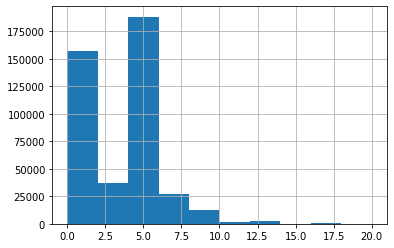

In [5]:
all_scores_list = [score for _, row in scrapes_dataset.iterrows() for score in ast.literal_eval(row['scores'])]

pd.Series(all_scores_list).hist()

### Find all ngrams:
For n in <1,4>

#### Method finding phrases grouped by scrape:
Phrase score is calculated as an average of component words scores

In [6]:
def get_phrases(words_list, scores_list, scrape_id):
  phrases_list = []
  for i in range(len(words)):
    phrase = []
    score_sum = 0
    for j in range(4):
      if i + j < len(words):
          phrase.append(words_list[i+j])
          score_sum += scores_list[i + j]
          phrases_list.append((scrape_id, ' '.join(phrase), score_sum/(j+1)))
  return phrases_list


### Generate dataframe with found phrases:

In [7]:
phrases_data = []
for name, group in scrapes_dataset.groupby('scrape_id'):
  for index, row in group.iterrows():
    words = ast.literal_eval(row['words'])
    words = [n.strip() for n in words]
    scores = ast.literal_eval(row['scores'])
    phrases_data += get_phrases(words, scores, name)

In [8]:
phrases_df = pd.DataFrame(phrases_data, columns=['scrape_id', 'phrase', 'score'])

### Plot phrases scores distribution:
As expected, the distribution of phrases scores is similar to the distribution of words scores

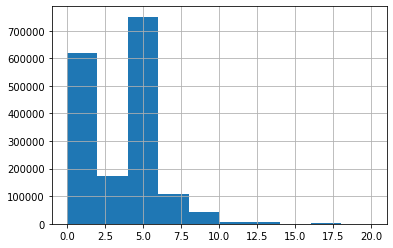

In [9]:
phrases_df['score'].hist()

### Calculate TF-IDF measures:

It was decided to score each phrase prominence using modified tfidf measure.
The modification consists in replacing the term frequency with the average phrase score.
The measures were counted treating the scrape as one document.

In [10]:
def calculate_phrase_sum_per_scrape_df(phrases_dataframe):
    return phrases_dataframe.groupby(['scrape_id', 'phrase'])\
        .sum()\
        .sort_values(by = 'score', ascending=False)\
        .reset_index()

def calculate_sum_total_per_scrape_df(terms_scores_sum_per_scrape_df):
    sum_total_per_scrape = terms_scores_sum_per_scrape_df.groupby(['scrape_id'])\
        .sum().sort_values(by = 'score', ascending=False)\
        .reset_index()
    sum_total_per_scrape.rename(columns = {'score': 'score_sum'}, inplace = True)
    return sum_total_per_scrape

def calculate_term_frequency_df(sum_total_scores_per_scrape_df, terms_scores_sum_per_scrape_df):
    term_frequencies = terms_scores_sum_per_scrape_df\
        .join(other = sum_total_scores_per_scrape_df.set_index('scrape_id'), on = 'scrape_id')
    term_frequencies['tf'] = term_frequencies.score / term_frequencies.score_sum
    return term_frequencies

def calculate_inverse_document_frequency_df(terms_scores_sum_per_scrape_df, scrapes_df):
    inverse_document_frequencies = \
        terms_scores_sum_per_scrape_df[['phrase', 'scrape_id']]\
            .groupby(['phrase']).count()\
            .sort_values(by = 'scrape_id', ascending=False)\
            .reset_index().rename(columns = {'scrape_id': 'occurances'})
    inverse_document_frequencies['idf'] = len(scrapes_df['scrape_id'].unique()) / inverse_document_frequencies.occurances
    inverse_document_frequencies['idf'] = inverse_document_frequencies['idf'].apply(math.log)
    return inverse_document_frequencies

def calculate_tfidf_dataframe(phrases_dataframe):
    terms_scores_sum_per_scrape_df = calculate_phrase_sum_per_scrape_df(phrases_dataframe)
    sum_total_scores_per_scrape_df = calculate_sum_total_per_scrape_df(terms_scores_sum_per_scrape_df)
    term_frequency_df = calculate_term_frequency_df(sum_total_scores_per_scrape_df, terms_scores_sum_per_scrape_df)
    inverse_document_frequency_df = calculate_inverse_document_frequency_df(terms_scores_sum_per_scrape_df, scrapes_dataset)
    tfidf_df = \
        term_frequency_df\
            .join(other = inverse_document_frequency_df.set_index('phrase'), on = 'phrase')
    tfidf_df['tfidf'] = tfidf_df.tf * tfidf_df.idf
    return tfidf_df

#### Calculate tfidfs and get the results:
The results seem plausible. There are repetitions for ngrams with different n (f.e. {abc, ab, bc}),
but due to the differing tfidf scores, the result is left as it is, however it is possible to filter out overlapping ngrams.

In [11]:
phrases_prominence_df = calculate_tfidf_dataframe(phrases_df)

top_prominence_phrases_df = \
    phrases_prominence_df.groupby('scrape_id').apply(lambda x: x.nlargest(10, 'tfidf'))\
    .reset_index(drop=True)\
        .join(scrapes_dataset[['scrape_id', 'scrape_keyword']].drop_duplicates().set_index('scrape_id'), on = 'scrape_id')

top_prominence_phrases_df.to_csv('results.csv')


### Plot the phrases prominence scores distribution:
As expected, the phrases prominence scores distribution is long tailed.

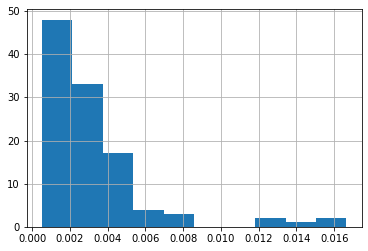

In [12]:
top_prominence_phrases_df['tfidf'].hist()